Given the four annotation files, it’s a good idea to choose one that balances data quantity with annotation reliability. Since **higher annotator agreement** likely means **better labeling accuracy**, the *sentences_75agree* file would be a solid choice, providing both a reliable and sizable dataset. 

This dataset’s 3,453 examples offer sufficient data without dropping to lower agreement levels that could introduce labeling inconsistency.

# Loading the data

In [6]:
import pandas as pd

In [7]:
def load_phrasebank(file_path):
    # Open the file and read lines
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        lines = f.readlines()

    # Process each line to separate sentence and sentiment
    data = []
    for line in lines:
        # Split on the '@' symbol
        parts = line.strip().split('@')
        if len(parts) == 2:
            sentence = parts[0].strip()
            sentiment = parts[1].strip()  # Sentiment should be one of "positive", "negative", or "neutral"
            data.append((sentence, sentiment))

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Sentence', 'Sentiment'])
    return df

In [8]:
df = load_phrasebank('/kaggle/input/financial-phrasebank/FinancialPhraseBank-v1.0/Sentences_75Agree.txt')
print(df.head())

                                            Sentence Sentiment
0  According to Gran , the company has no plans t...   neutral
1  With the new production plant the company woul...  positive
2  For the last quarter of 2010 , Componenta 's n...  positive
3  In the third quarter of 2010 , net sales incre...  positive
4  Operating profit rose to EUR 13.1 mn from EUR ...  positive


In [9]:
df.tail()

,Sentence,Sentiment
3448,Operating result for the 12-month period decre...,negative
3449,HELSINKI Thomson Financial - Shares in Cargote...,negative
3450,LONDON MarketWatch -- Share prices ended lower...,negative
3451,Operating profit fell to EUR 35.4 mn from EUR ...,negative
3452,Sales in Finland decreased by 10.5 % in Januar...,negative


In [10]:
df.Sentiment.value_counts()

Sentiment
neutral     2146
positive     887
negative     420
Name: count, dtype: int64

# Preprocessing Text for the BiLSTM Model

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
import numpy as np

**Tokenize the sentences**

In [13]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'])
sequences = tokenizer.texts_to_sequences(df['Sentence'])

**Pad sequences to ensure uniform input size**

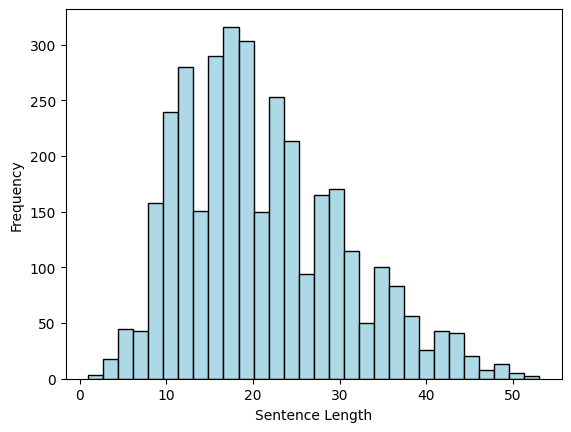

Max length: 53
Average length: 21.10
90th percentile length: 35.0


In [14]:
# Calculate the length of each sentence in terms of tokens
sentence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df['Sentence'])]

# Plot the distribution 
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=30, color='lightblue', ec='black')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

# Get some statistics on sentence lengths
import numpy as np
print(f'Max length: {np.max(sentence_lengths)}')
print(f'Average length: {np.mean(sentence_lengths):.2f}')
print(f'90th percentile length: {np.percentile(sentence_lengths, 90)}')

In [15]:
max_length = 53
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [16]:
# Inspect the tokenizer's vocabulary
vocab_size = len(tokenizer.word_index) + 1  # add 1 for padding token
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 8134


**Encode sentiments to integers**

In [17]:
sentiment_labels = {'positive': 2, 'neutral': 1, 'negative': 0}
df['Sentiment'] = df['Sentiment'].map(sentiment_labels)
y = df['Sentiment'].values

In [18]:
df.head()

,Sentence,Sentiment
0,"According to Gran , the company has no plans t...",1
1,With the new production plant the company woul...,2
2,"For the last quarter of 2010 , Componenta 's n...",2
3,"In the third quarter of 2010 , net sales incre...",2
4,Operating profit rose to EUR 13.1 mn from EUR ...,2


# Building the BiLSTM Model with GloVe-6b-100d

In [19]:
# Load GloVe embeddings
embedding_dim = 100  # or 200, 300, depending on the GloVe file
embedding_index = {}
with open("/kaggle/input/glove-embeddings/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create the embedding matrix
vocab_size = len(tokenizer.word_index) + 1  
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Model Parameters
# vocab_size
# embedding_dim = 128  # size of the embedding vector - GloVe
lstm_units = 64  # units in the LSTM layer

**Define the model**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, Attention, Layer

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [25]:
from tensorflow.keras.models import Model
#? from tensorflow.keras import layers

In [26]:
from sklearn.utils.class_weight import compute_class_weight

In [27]:
import tensorflow as tf

In [32]:
from tensorflow.keras.layers import MultiHeadAttention

## Model with multi-head attention layer


In [34]:
# Define a custom pooling layer to handle reduce_sum within Keras
class SumPooling(Layer):
    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

In [35]:
# Define the model
def create_model(vocab_size, embedding_dim, embedding_matrix, dropout_rate=0.5, lstm_units=128):
    inputs = Input(shape=(None,))
    
    # Pre-trained GloVe embeddings (non-trainable)
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                  weights=[embedding_matrix], trainable=False)(inputs)
    
    # Bidirectional LSTM with return_sequences=True to keep all time steps
    x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(x)
    
    # Attention Layer
    x = MultiHeadAttention(num_heads=4, key_dim=lstm_units)(x, x)
    x = SumPooling()(x)  # Pooling to combine multi-head output
    
    # Dense layers for classification
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(3, activation='softmax')(x)  # 3 sentiment classes
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
# Parameters
embedding_dim = 100
dropout_rate = 0.5
lstm_units = 128

In [37]:
model = create_model(vocab_size, embedding_dim, embedding_matrix, dropout_rate=0.5, lstm_units=128)

In [38]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 100) │    813,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, None, 256) │    234,496 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │    526,080 │ bidirectional_2[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_pooling         │ (None, 256)       │          0 │ multi_head_atten… │
│ (SumPooling)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ sum_pooling[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,590,619 (6.07 MB)

 Trainable params: 777,219 (2.96 MB)

 Non-trainable params: 813,400 (3.10 MB)

# Train the Model

In [42]:
# Define class weights to address class imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=[0, 1, 2], y=y)
class_weights_dict = dict(enumerate(class_weights))

In [43]:
class_weights_dict # gives more weightage to the classes with less samples

{0: 2.7404761904761905, 1: 0.5363466915191053, 2: 1.2976324689966179}

In [44]:
from sklearn.model_selection import train_test_split

**Split data into training, validation and testing sets**

In [45]:
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, y, test_size=0.1, random_state=42, stratify=y)  # 80-20 split for test set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)  # 60-20-20 split

In [46]:
print(f'X Train : {len(X_train)} X Val : {len(X_val)} X Test : {len(X_test)}')
print(f'Y Train : {len(y_train)} Y Val : {len(y_val)} Y Test : {len(y_test)}')

X Train : 2796 X Val : 311 X Test : 346
Y Train : 2796 Y Val : 311 Y Test : 346


In [47]:
y_train[32:35]

array([1, 2, 0])

In [48]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [49]:
y_train_cat[32:35]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

**Train the model**

In [50]:
epochs = 20
patience = 5

In [51]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [52]:
history = model.fit(
    X_train, y_train_cat,
    epochs=epochs,
    batch_size=64,
    validation_data=(X_val, y_val_cat),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 384ms/step - accuracy: 0.4353 - loss: 1.5236 - val_accuracy: 0.5981 - val_loss: 0.9473
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.6187 - loss: 0.9314 - val_accuracy: 0.6688 - val_loss: 0.7523
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.6628 - loss: 0.7948 - val_accuracy: 0.6077 - val_loss: 0.8970
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.6662 - loss: 0.7849 - val_accuracy: 0.6592 - val_loss: 0.7672
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.7031 - loss: 0.7144 - val_accuracy: 0.5916 - val_loss: 0.8613
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.6594 - loss: 0.7835 - val_accuracy: 0.7042 - val_loss: 0.5987
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.7018 - loss: 0.7208 - val_accuracy: 0.7299 - val_loss: 0.6046
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.6984 - loss: 0.7061 - val_accu

# Evaluating the Model

In [53]:
# Get predictions on the test set
y_pred_prob = model.predict(X_test)  # Returns probabilities

# Convert probabilities to class labels (argmax to get the class with the highest probability)
y_pred = y_pred_prob.argmax(axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


In [54]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Test Accuracy: 0.8988
              precision    recall  f1-score   support

    Negative       0.80      0.88      0.84        42
     Neutral       0.93      0.93      0.93       215
    Positive       0.87      0.83      0.85        89

    accuracy                           0.90       346
   macro avg       0.87      0.88      0.87       346
weighted avg       0.90      0.90      0.90       346



In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
def predict_sentiment(sentence):
    #sentence = input("Sentence: ")
    print(f"Sentence: {sentence}")
    
    # Convert the sentence to a sequence of token IDs
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    
    # Pad the sequence to match the input length your model expects
    sentence_padded = pad_sequences(sentence_seq, maxlen=max_length, padding='post')
    
    # Predict the sentiment
    prediction = model.predict(sentence_padded)
    
    # Get the class with the highest probability
    predicted_class = prediction.argmax(axis=1)[0]
    
    # Map the predicted class back to the sentiment label
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_labels[predicted_class]
    
    print(f"Predicted Sentiment: {predicted_sentiment}")

In [68]:
predict_sentiment("The company's performance this year has been exceptionally great with significant growth.")

Sentence: The company's performance this year has been exceptionally great with significant growth.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Sentiment: Positive


In [73]:
predict_sentiment("Apple's performance in quarter 4 of 2023 has gotten significantly worse.")

Sentence: Apple's performance in quarter 4 of 2023 has gotten significantly worse.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Sentiment: Negative


# Save the model

In [75]:
model.save('/kaggle/working/sa_bilstm_100d_mha_90ACC.h5')
model.save('/kaggle/working/sa_bilstm_100d_mha_90ACC.keras')

-------------------------------------------------